# Demonstration book for Hn-NSF

This is the demonstration book for Hn-NSF. By using this book, we are going to 

* Define a Hn-NSF based on function blocks such as 1D CNN, sine waveform generator
* Load pre-trained Hn-NSF model and generate waveform samples

Details of the function blocks are introduced in NNN of this Hands-on session.

Requirements:
* A python3 environment with Pytorch-1.4 or later
* numpy, scipy, 
* matplotlib


## 1. Define Hn-NSF model

Since Hn-NSF is built on the basis of 1D CNN and other NN funciton blocks. These NN function blocks can be briefly grouped into three modules: the condition module, the source module, and the neural filter module. This section will walk through the general framework of Hn-NSF model.


### 1.1 Preparation

Let's load the packages and basic NN functions:

In [1]:
# At the begining, let's load packages 
from __future__ import absolute_import
from __future__ import print_function
import sys
import numpy as np
import torch
import torch.nn as torch_nn
import torch.nn.functional as torch_nn_func

# load the basic function blocks
import data_models.pre_trained_hn_nsf.model as nii_nn_blocks

# misc functions for this demonstration book
import plot_lib
import tool_lib
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (10, 5)


All the necessary NN function blocks are defined in *data_models/pre_trained_hn_nsf/model.py*

### 1.2 Condition module

Picture here [] 

Picture above shows the network structure of the condition module. This is module has two specific goals: 
1. Up-sample the input F0 sequence
2. Transform and upsample the input acoustic features (e.g., Mel-spec, and F0)

It is straightforward to define the Condition Module

In [2]:
class CondModule(torch_nn.Module):
    """ Conditiona module
    Upsample and transform input features
    
    Initialization:
    CondModule(input_dim, output_dim, up_sample,
               blstm_s = 64, cnn_kernel_s = 3)
        input_dime: dimension of input features 
        output_dim: dimension of output features for neural filter module
        up_sample: up-sampling rate
        blstm_s: dimension of the hidden Bi-LSTM RNN layer
        cnn_kernel_s: kernel size of the output CNN layer
      
    Method:
    Spec_upsampled, F0_upsampled = CondModule(features, F0)
    
        feature: (batchsize, length, dim)
        f0: (batchsize, length, dim=1), 
        
        spec_upsampled: (batchsize, length * up_sample, output_dim)
        f0_upsampled: (batchsize, length * up_sample, 1)
    
    """
    def __init__(self, input_dim, output_dim, up_sample, \
                 blstm_s = 64, cnn_kernel_s = 3):
        super(CondModule, self).__init__()
        
        # config
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.up_sample = up_sample
        self.blstm_s = blstm_s
        self.cnn_kernel_s = cnn_kernel_s

        # Bi-LSTM layer  (batchsize, length, input_dim) -> (batchsize, length, blsmt_s)
        self.l_blstm = nii_nn_blocks.BLSTMLayer(input_dim, self.blstm_s)
        
        # 1D CNN with stride=1  (batchsize, length, blsmt_s) -> (batchsize, length, output_dim)
        self.l_conv1d = nii_nn_blocks.Conv1dKeepLength(self.blstm_s, output_dim, 1, self.cnn_kernel_s)
        
        # up-sampling layer with smoothing=True 
        # (batchsize, length, output_dim) -> (batchsize, length*up_sample, output_dim)
        self.l_upsamp = nii_nn_blocks.UpSampleLayer(self.output_dim, self.up_sample, True)
        
        # Upsampling for F0: don't smooth up-sampled F0
        self.l_upsamp_F0 = nii_nn_blocks.UpSampleLayer(1, self.up_sample, False)

    def forward(self, feature, f0):
        spec_trans_upsampled = self.l_upsamp(self.l_conv1d(self.l_blstm(feature)))
        f0_upsampled = self.l_upsamp_F0(f0)
        return spec_trans_upsampled, f0_upsampled


Let's try some toy examples to show how eacy layer works

In [3]:
# Create an input feature matrix of size (batchsize, frame_length, feature_dim)
frame_length = 30
feature_dim = 16
batchsize = 2
input_feature = torch.rand(batchsize, frame_length, feature_dim)

# Assume f0 is the last dimension of the input_feature matrix
#  please remember to shape F0 as (batchsize, frame_length, 1), not (batchsize, frame_length)
input_f0 = input_feature[:, :, -1:]

# Initialzie a Condition module, which up-samples input feature for 80 times
# (80 = 16 kHz * 5 ms frame-shift)
output_dim = 16
up_sample = 80
m_cond = CondModule(feature_dim, output_dim, up_sample)

with torch.no_grad():
    spec_upsampled, f0_upsampled = m_cond(input_feature, input_f0)


Input feature shape: torch.Size([2, 30, 16])
Output spec-feature shape: torch.Size([2, 2400, 16])
Input F0 shape: torch.Size([2, 30, 1])
Output F0 shape: torch.Size([2, 2400, 1])


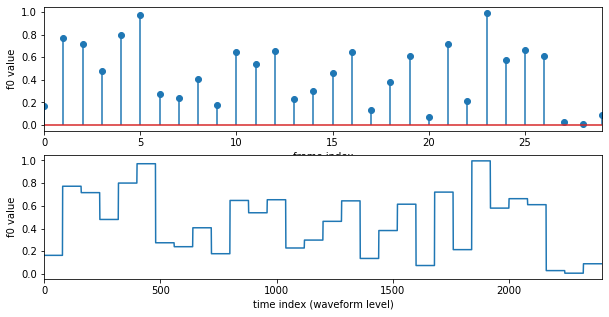

In [9]:
# Do a simple check
print("Input feature shape: %s" % (str(input_feature.shape)))
print("Output spec-feature shape: %s" % (str(spec_upsampled.shape)))
print("Input F0 shape: %s" % (str(input_f0.shape)))
print("Output F0 shape: %s" % (str(f0_upsampled.shape)))

fig = plt.figure()
axis = fig.add_subplot(211)
fig, axis = plot_lib.plot_signal_stem(input_f0[0, :, 0].numpy(), fig, axis, "frame index", "f0 value")
axis = fig.add_subplot(212)
fig, axis = plot_lib.plot_signal(f0_upsampled[0, :, 0].numpy(), fig, axis, "time index (waveform level)", "f0 value")